<center>
   <img src="https://miro.medium.com/max/4800/1*cDwKSHmfp5awjqjobV707g.png">
</center>   

# 1. Introduction

<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Topic Modelling Purpose</b></p>
</div>

To extract topics of a given text by
> * by scanning unstructured text to detect keywords, topics, and themes

**Dataset Description [Dataset](https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022)**

Total 5 Columns
> * `Time_submitted` : At what time the review was submitted
> * `Review` : Review text
> * `Rating` : Given score (1-5)
> * `Total_thumbsup` : How many people found the review helpful
> * `Reply` : Review reply

<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.2 What is Topic Modelling?</b></p>
</div>

> * It's a Natural Language Processing (NLP) technique, which utilizes unsupervised learning methods to extract the main topics
> * “Unsupervised” means there are no training data that have associated topic labels
> * Rather, the algorithms try to discover the underlying patterns, in this case, the topics, directly from the data itself
<hr>

<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.3 Libraries</b></p>
</div>

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns


import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Useful for storing big datasets
import pickle

import gensim
from gensim.models import CoherenceModel, LdaMulticore

!pip install pyldavis
import pyLDAvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


# 2. Data
<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 Data Frames</b></p>
</div>

In [2]:
# Read csv file
df = pd.read_csv("/kaggle/input/spotify-app-reviews-2022/reviews.csv")

# show first few entries
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [3]:
# Use Only "Review", "Rating" Columns
data = df[["Review", "Rating"]]
data.head()

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [4]:
# Short Info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  61594 non-null  object
 1   Rating  61594 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.5+ KB


In [5]:
data.shape

(61594, 2)

In [6]:
# Dropping duplicate Reviews
data.drop_duplicates(subset='Review', inplace=True, ignore_index=True)
data.shape

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(61356, 2)

**Same Reviews** have occurred **several times**, those are **removed**

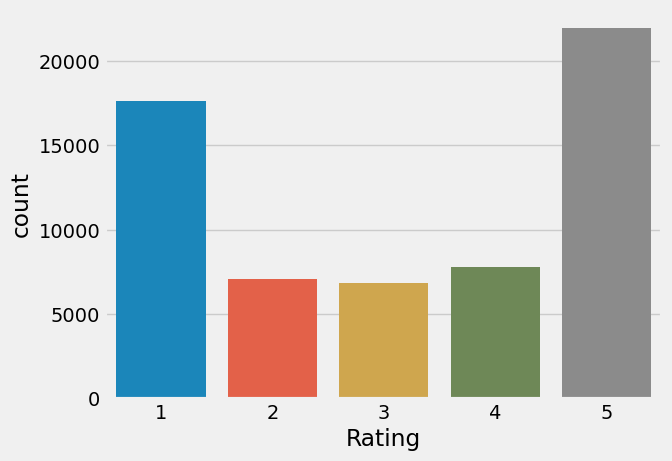

In [7]:
# Create countplot with value counts
sns.countplot(data, x='Rating');

**Positive rating** as well as **negative ratings** are **high**

# 3. Data Preparing
<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Data Cleaning</b></p>
</div>

> * Remove URLs, mentions and hash tags using the **sub function** of **regular expression package** 
> * Lowercase each word
> * Replace contractions with their longer forms

In [8]:
# Remove URL, mentions and hashtags
def remove_url_mentions_hashtag(text):
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    text = re.sub(r'@\S*','',text)
    return re.sub(r'#\S*','',text)

data.Review = data.Review.apply(remove_url_mentions_hashtag)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
# Defining Contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have"    
}

In [10]:
# Expand contractions
def remove_contractions(text):
    text = text.lower()
    
    text = text.split()
    new_text = []
    
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
            
    text = " ".join(new_text)
    
    return text

data.Review = data.Review.apply(remove_contractions)

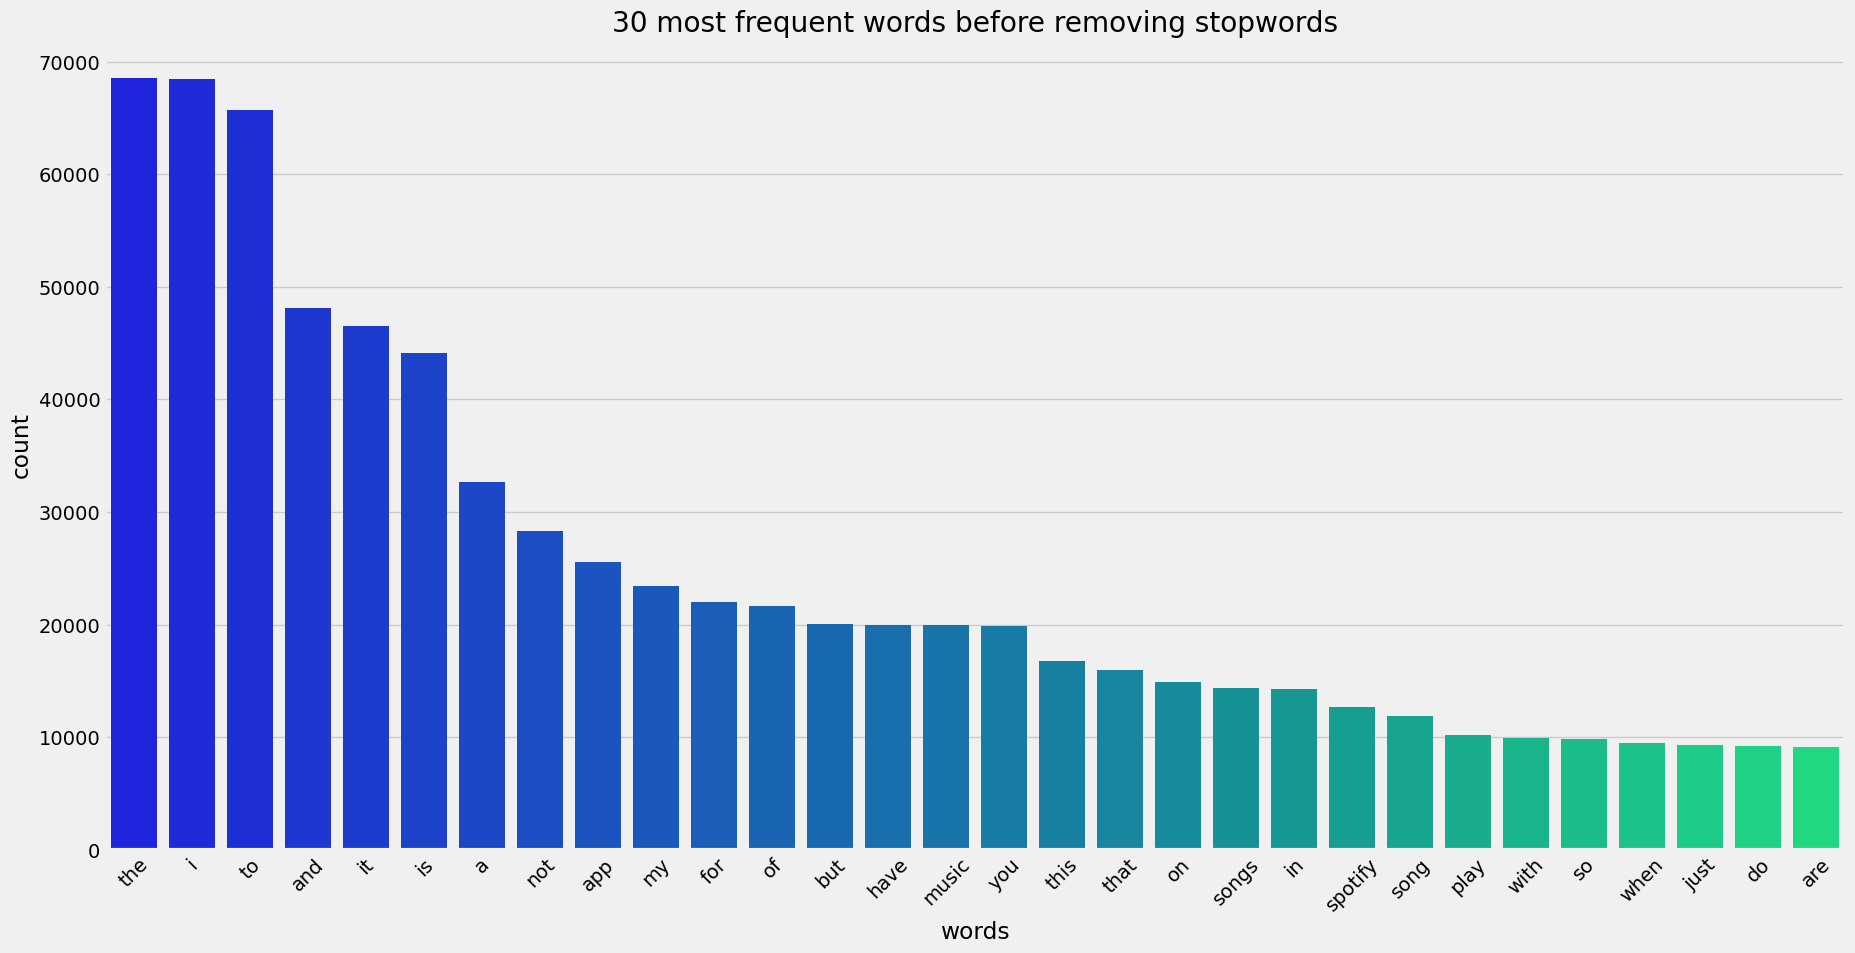

In [11]:
# Join all words
review_words = ','.join(list(data['Review'].values))

# Count and find the 30 most frequent
counter = Counter(review_words.split())
most_frequent = counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize=(20,10))
_ = pd.DataFrame(most_frequent, columns=('words', 'count'))
sns.barplot(x='words', y='count', data= _, palette='winter')
plt.xticks(rotation=45)
plt.title("30 most frequent words before removing stopwords");

* As expected there are `frequent words` in the `top 30`, related to Spotify App and song such as **“spotify”**, **“app”**, **"song"**, **"songs"** and **“music”**. 
* We will **remove** these words by **adding** them to the **stopwords list**

<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.2 Data Preprocessing</b></p>
</div>

* **Lemmatization** : **WordNetLemmatizer().lemmatize()** reduces words to their **base form** or **lemma**. For example, the lemma of the word "am", "are", and "is" is "be", and the lemma of "running" is "run".
* **PreProcessing** : **gensim.utils.simple_preprocess()** preprocess and tokenize text data, which is a necessary step in many natural language processing tasks, like text classification, sentiment analysis, and topic modeling by performing:
    * Lowercasing the text

    * Tokenization

    * Filtering out stop words

    * Filtering out tokens with length less than 2

    * Filtering out tokens with non-alphabetic characters
    
    * Removing the accents by setting deacc to True

In [12]:
stopwords_list = stopwords.words('english')
stopwords_list.extend(["spotify", "app", "song","music", "songs"])

def lemmatization(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in stopwords_list:
            result.append(lemmatization(token))
            
    return result

data["Review_Clean_List"] = data.Review.apply(preprocess)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [13]:
# Convert list to string
def to_string(text):
    text = ' '.join(map(str, text))
    return text

data['Review_Clean'] = list(map(to_string, data['Review_Clean_List']))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
data[data["Review_Clean_List"].str.len() == 0]

,Review,Rating,Review_Clean_List,Review_Clean
1212,100% has everything!,5,[],
3684,in this app all songs are there,3,[],
8899,there are others out there but i always go bac...,5,[],
9201,spotify and only spotify for me!,5,[],
14070,every songs is there !!,5,[],
17678,it does not have all the songs,1,[],
18473,could not ever be without my spotify.,5,[],
20056,all the songs ever made. or most of them..,4,[],
23068,it is spotify after all,5,[],
24259,it has all songs which other song app does not...,5,[],


There are several **reviews** which become **list of empty string** after **text preprocessing**, they should be removed

In [15]:
data = data[data["Review_Clean_List"].str.len() != 0]

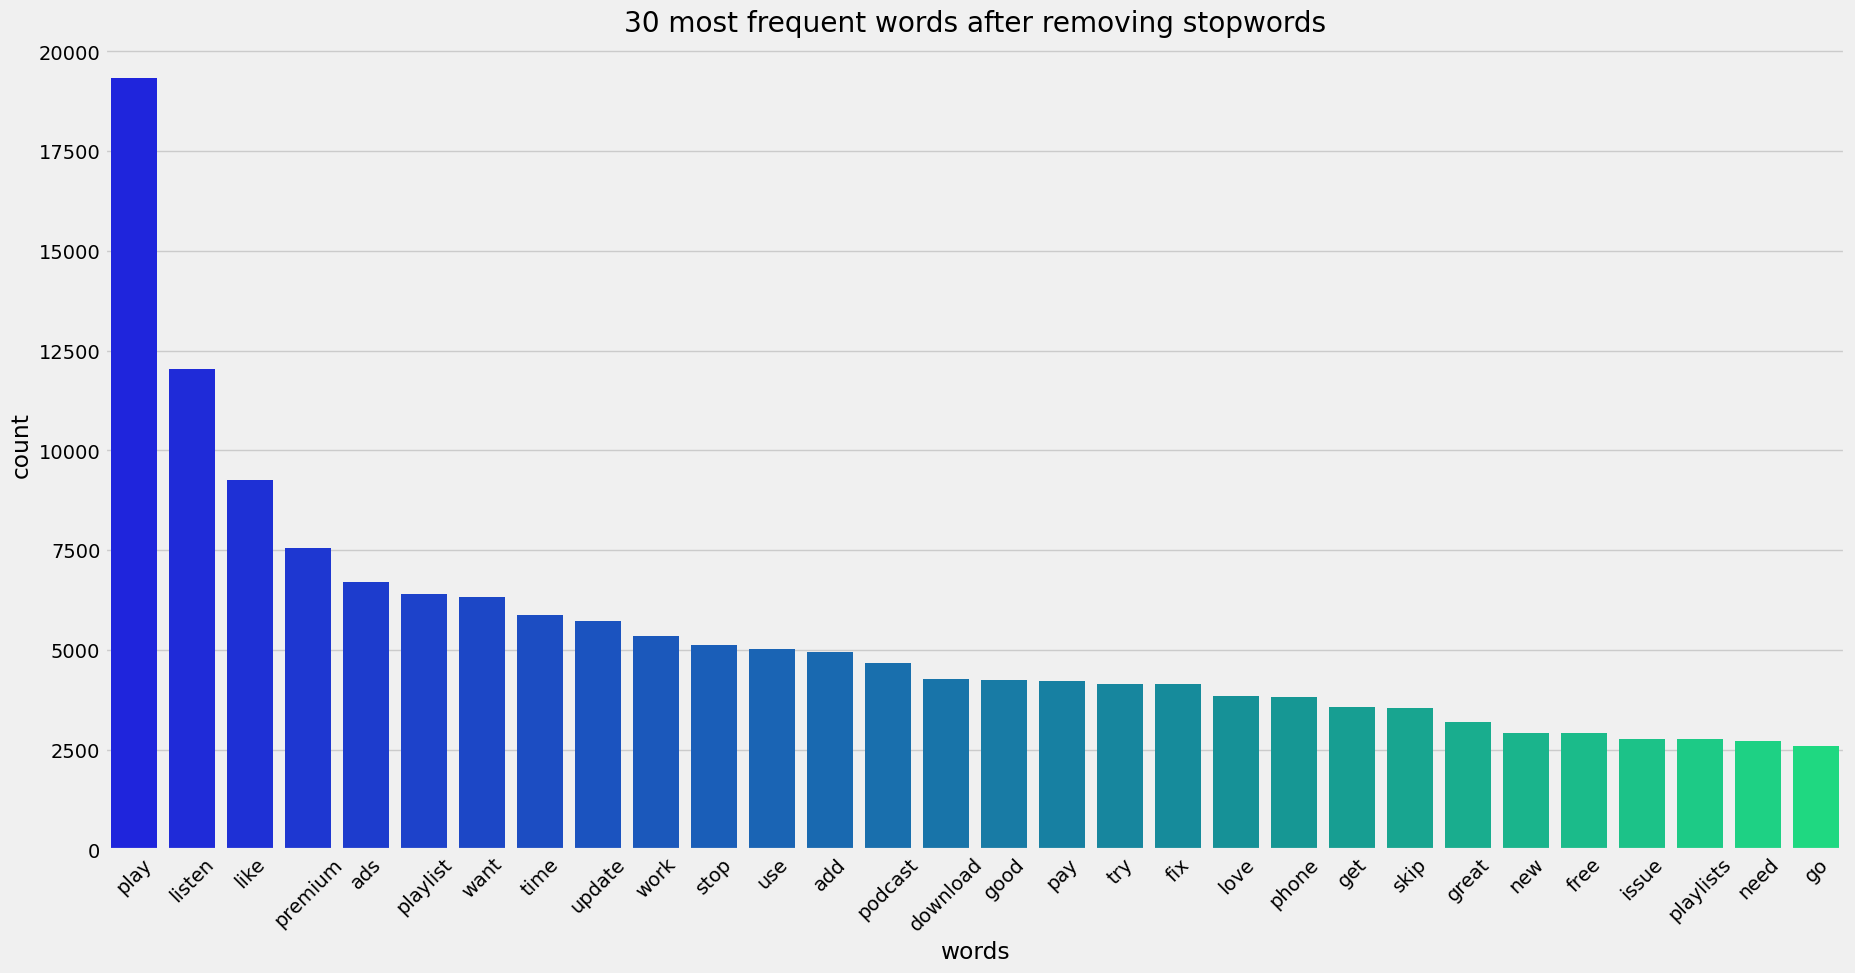

In [16]:
# Join all words
review_words = ','.join(list(data['Review_Clean'].values))

# Count and find the 30 most frequent
counter = Counter(review_words.split())
most_frequent = counter.most_common(30)

# Bar plot of frequent words
fig = plt.figure(1, figsize=(20,10))
_ = pd.DataFrame(most_frequent, columns=('words', 'count'))
sns.barplot(x='words', y='count', data= _, palette='winter')
plt.xticks(rotation=45)
plt.title("30 most frequent words after removing stopwords");

**30 most frequent words** are **different** **before** and **after** `removing stopwords`

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/con

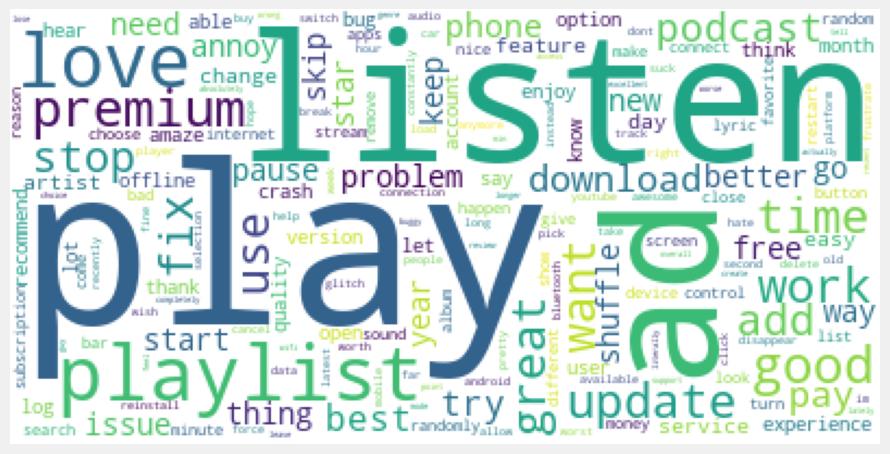

In [17]:
# Generate the word cloud
wordcloud = WordCloud(background_color='white', 
                      max_words=200, 
                      contour_width=8, 
                      contour_color='steelblue', 
                      collocations=False).generate(review_words)

# Visualize the word cloud
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

**Word Cloud** of the **preprocessed text corpus** is created using `review_words`

<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.3 Bag-of-Words on Documents</b></p>
</div>

* It's **vector space model** which represents the **occurrence of words** in the document **without** giving **importance** to the **order** or **meaning**
* **dictionary** is created using **corpora.Dictionary** of `Gensim Package`. Here, we **map each word** with an **integer id** i.e. `id2word`
* **bag-of words** is created using **dictionary.doc2bow**. Here, **doc2bow** function is called on each dictionary to create a list of `(id, frequency) tuples`.

In [18]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data["Review_Clean_List"])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data["Review_Clean_List"]]

# 4. Determining the Number of Topics
<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Coherence Score</b></p>
</div>

* Deciding on the **number of topics** for the `topic modeling` can be **difficult**. 
* If this **number** is **too much** then the model might **fail** to **detect a topic** that is actually `broader` 
* If this **number** is **too less** then topics might have **large overlapping words**. 
* Here, the `topic coherence score` comes to **rescue**

In [21]:
pd.set_option('display.max_colwidth', 15000)
data.sample()

,Review,Rating,Review_Clean_List,Review_Clean
6678,"best music app that i know of, but sometimes it gives me short clips thst are shorter than preview clips on my samsung(s). or prehaps, there is a setting that i overlooked.. spotify is the fiurst music app that i have emgareed, kind of easy to move around. keep it up!!!",5,"[best, know, give, short, clip, thst, shorter, preview, clip, samsung, prehaps, set, overlook, fiurst, emgareed, kind, easy]",best know give short clip thst shorter preview clip samsung prehaps set overlook fiurst emgareed kind easy


In [22]:
# Compute coherence score
no_of_topics = []
coherence_score = []

for i in range(2,7):
    lda_model = LdaMulticore(corpus=corpus, 
                            id2word=id2word,
                            iterations=50,
                            num_topics=i,
                            passes=10,
                            workers=2)
    
    # Instantiate topic coherence model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data["Review_Clean_List"], dictionary=id2word, coherence='c_v')
    
    # Get topic coherence score
    coherence_lda = coherence_model_lda.get_coherence()
    no_of_topics.append(i)
    coherence_score.append(coherence_lda)

In [23]:
# Create a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics':no_of_topics,
                               'coherence_score':coherence_score})

# Print topic_coherence dataframe
topic_coherence 

,number_of_topics,coherence_score
0,2,0.455476
1,3,0.475188
2,4,0.506146
3,5,0.549537
4,6,0.520766


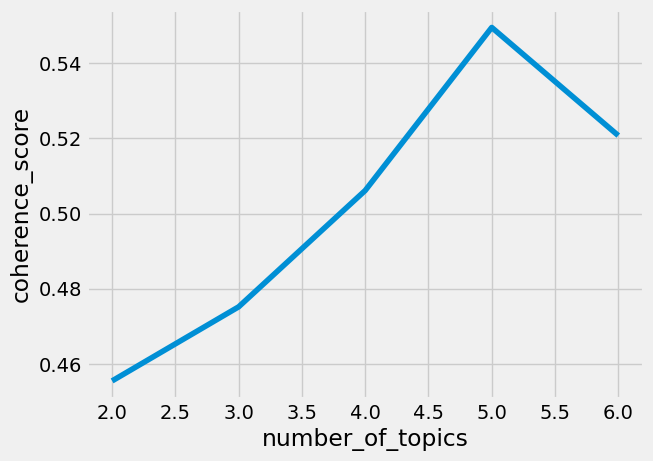

In [24]:
# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score');

* Since a very high coherence score (0.549537) is achieved with five topics, we will construct our LDA model with five topics. 

* However, we defined the **coherence hyperparameter** as **coherence='c_v'** but there are other options as well such as **‘u_mass’**, **‘c_uci’**, **‘c_npmi'**.

# 5. Topic Modelling with LDA
<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>5.1 LDA(Latent Dirichlet Allocation)</b></p>
</div>

* `Latent Dirichlet Allocation(LDA)` is a statistical **unsupervised** machine learning model for **topic modeling**
* LDA assumes **each topic** is made up of **words** and **each document** (in our case each review) consists of a **collection** of **these words**. 
* LDA tries to **find words** that **best describe each topic** and **matches reviews** that are **represented** by these words.

In [25]:
lda_model_5 = LdaMulticore(corpus, num_topics=5, id2word=id2word, passes=8, workers=3)

In [26]:
# Print words occuring in each of the topics
for idx, topic in lda_model_5.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.088*"ads" + 0.057*"good" + 0.031*"listen" + 0.023*"use" + 0.022*"easy" + 0.021*"ad" + 0.020*"best" + 0.020*"like" + 0.019*"great" + 0.017*"love"

Topic: 1 
Words: 0.065*"play" + 0.046*"playlist" + 0.046*"listen" + 0.043*"want" + 0.040*"like" + 0.023*"add" + 0.018*"skip" + 0.017*"shuffle" + 0.010*"good" + 0.010*"premium"

Topic: 2 
Words: 0.046*"play" + 0.025*"work" + 0.024*"stop" + 0.024*"update" + 0.021*"fix" + 0.016*"time" + 0.016*"phone" + 0.014*"issue" + 0.012*"try" + 0.010*"pause"

Topic: 3 
Words: 0.055*"premium" + 0.037*"pay" + 0.021*"service" + 0.016*"free" + 0.015*"stream" + 0.013*"subscription" + 0.013*"download" + 0.011*"use" + 0.011*"money" + 0.010*"user"

Topic: 4 
Words: 0.045*"love" + 0.028*"podcast" + 0.027*"great" + 0.025*"listen" + 0.017*"like" + 0.016*"lyric" + 0.013*"playlists" + 0.013*"new" + 0.013*"thank" + 0.012*"feature"


# 6. Visualizing LDA Results
<div style="color:white;display:fill;
            background-color:#ac39ac;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>6.1 Using pyLDAvis</b></p>
</div>

In [27]:
# Visualize the LDA results
from pyLDAvis import gensim

vis = pyLDAvis.gensim.prepare(lda_model_5, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


On the **left side** of the the `pyLDAvis dashboard`, the **area of each circle** represents the **importance** of the **topic** relative to the **corpus**. In addition, the **distance** between the **center of the circles** indicates the `similarity between the topics`.

Now on the **right side** of the dashboard, the `top 30 relevant words` of each topic are displayed in a **histogram** with the **red portion** of the bar representing the estimated **term frequency** within the **selected topic** (saliency) and the **light blue portion** representing the **overall term frequency**.

# 7. References
* https://medium.com/swiftworld/topic-modeling-of-new-york-times-articles-11688837d32f
* https://towardsdatascience.com/let-us-extract-some-topics-from-text-data-part-i-latent-dirichlet-allocation-lda-e335ee3e5fa4
* https://towardsdatascience.com/hands-on-topic-modeling-with-python-1e3466d406d7